📂 Danh sách ảnh:
1. GRV.jpg
2. KPT.jpg
3. NoiKhoa_Yen.webp
4. QDan.jpg
5. SieuAm.webp
6. TA_ThaoNhi.png
7. TV_ThimHuong.jpg
✅ Ảnh đã chọn: d:\Workspace\Intern_Bdata\n6_ocrmedical\data\GRV.jpg
🏆 Chọn phiên bản cuối: no_noise (sharpness=31860.54)
[2025/08/20 14:57:18] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\84382/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.8, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales

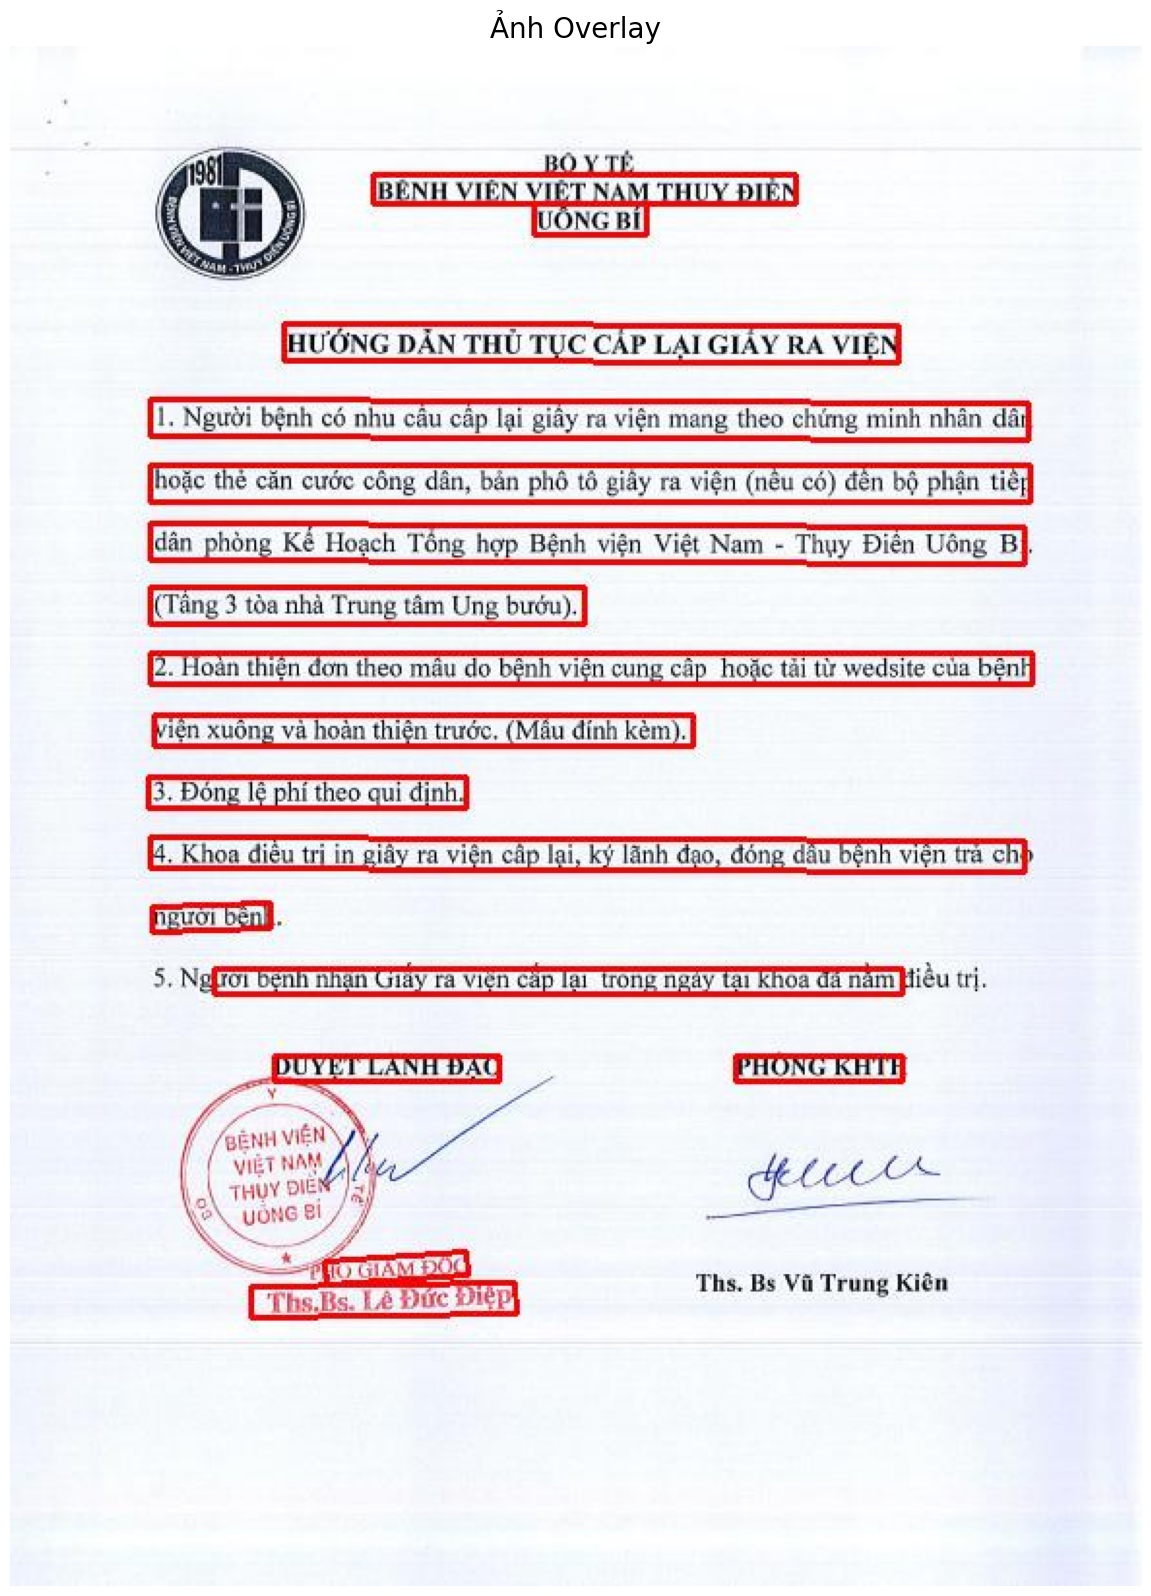

ℹ️ Không tìm thấy weights tuỳ chỉnh, dùng pretrained mặc định.
Model weight C:\Users\84382\AppData\Local\Temp\vgg_seq2seq.pth exsits. Ignore download!

===== 📄 KẾT QUẢ VIETOCR =====
BỆNH VIỆN VIỆT NAM THỤY ĐIỂN
UỒNG BÍ
HƯỚNG DĂN THỦ TỤC CẤP LẠI GIẤY RA VIỆN
1. Người bệnh có nhu cầu cấp lại giấy ra viện mang theo chứng minh nhân dân
hoặc thẻ căn cước công dân, bản phô tô giấy ra viện (nếu có) đến bộ phận tiếp
dân phòng Kế Hoạch Tổng hợp Bệnh viện Việt Nam - Thụy Điển Uông Bí
(Tầng 3 tòa nhà Trung tâm Ung bướu)
2, Hoàn thiện đơn theo mẫu do bệnh viện cung cấp hoặc tải từ wedsite của bệnh
viện xuống và hoàn thiện trước. (Mẫu đính kèm)
3. Đóng lệ phí theo qui định.
4, Khoa điều trị in giấy
người bệnh
Người bệnh nhận Giây ra viện cấp lại trong ngày tại khoa đã năm điều
DUYỆT LÀNH ĐẠO PHÒNG KHTH
PHO GIÁM ĐỐC
Ths. Bs. Lê Đức Điệp


In [3]:
# =========================
# 0) IMPORTS
# =========================
import os
import re
import cv2
import numpy as np
from paddleocr import PaddleOCR, draw_ocr
from PIL import Image
from matplotlib import pyplot as plt
from pathlib import Path

# =========================
# TIỆN ÍCH
# =========================
def display(im_path, title=None):
    im_path = str(im_path)
    img = plt.imread(im_path)
    plt.figure(figsize=(20, 20))
    if title:
        plt.title(title, fontsize=20)
    plt.axis('off')
    plt.imshow(img)
    plt.show()

def auto_invert_if_needed(bgr_img):
    gray = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
    if gray.mean() < 120:
        return cv2.bitwise_not(bgr_img)
    return bgr_img

def noise_removal(image):
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    return cv2.medianBlur(image, 3)

def thin_font(image):
    inv = cv2.bitwise_not(image)
    eroded = cv2.erode(inv, np.ones((2,2),np.uint8), iterations=1)
    return cv2.bitwise_not(eroded)

def thick_font(image):
    inv = cv2.bitwise_not(image)
    dilated = cv2.dilate(inv, np.ones((2,2),np.uint8), iterations=1)
    return cv2.bitwise_not(dilated)

def sharpness_score(img_bin):
    return cv2.Laplacian(img_bin, cv2.CV_64F).var()

def pad_bbox_xyxy(x1, y1, x2, y2, W, H, pad_y_ratio=0.12, pad_x_ratio=0.06):
    bw = max(1, x2 - x1)
    bh = max(1, y2 - y1)
    px = int(bw * pad_x_ratio)
    py = int(bh * pad_y_ratio)
    x1p = max(0, x1 - px)
    y1p = max(0, y1 - py)
    x2p = min(W - 1, x2 + px)
    y2p = min(H - 1, y2 + py)
    return x1p, y1p, x2p, y2p

# =========================
# 1) CHỌN ẢNH
# =========================
CWD = Path.cwd()                          # .../Intern_Bdata/n6_ocrmedical
DATA_DIR = CWD / "data"           # .../Intern_Bdata/data
OUTPUT_DIR = CWD / "output"               # .../Intern_Bdata/n6_ocrmedical/output
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

image_files = [p for p in DATA_DIR.iterdir() if p.suffix.lower() in {".png",".jpg",".jpeg",".bmp",".tif",".tiff",".webp"}]
if not image_files:
    raise SystemExit(f"❌ Không tìm thấy ảnh trong thư mục: {DATA_DIR}")

print("📂 Danh sách ảnh:")
for i, p in enumerate(sorted(image_files), 1):
    print(f"{i}. {p.name}")

choice = int(input("➡ Chọn số tương ứng: "))
image_path = sorted(image_files)[choice-1]

print(f"✅ Ảnh đã chọn: {image_path}")

# =========================
# 2) TIỀN XỬ LÝ
# =========================
img = cv2.imread(str(image_path))
if img is None:
    raise SystemExit(f"❌ Không đọc được ảnh: {image_path}")
cv2.imwrite(str(OUTPUT_DIR / "step0_input.jpg"), img)

img_proc = auto_invert_if_needed(img)
cv2.imwrite(str(OUTPUT_DIR / "step1_invert.jpg"), img_proc)

gray_image = cv2.cvtColor(img_proc, cv2.COLOR_BGR2GRAY)
bw = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                           cv2.THRESH_BINARY, 31, 2)
cv2.imwrite(str(OUTPUT_DIR / "step2_bw.jpg"), bw)

no_noise = noise_removal(bw)
cv2.imwrite(str(OUTPUT_DIR / "step3_no_noise.jpg"), no_noise)

thin_img = thin_font(no_noise)
thick_img = thick_font(no_noise)

candidates = {
    "no_noise": (no_noise, sharpness_score(no_noise)),
    "thin": (thin_img, sharpness_score(thin_img)),
    "thick": (thick_img, sharpness_score(thick_img)),
}
final_name, (final_img, best_score) = max(candidates.items(), key=lambda kv: kv[1][1])
print(f"🏆 Chọn phiên bản cuối: {final_name} (sharpness={best_score:.2f})")
cv2.imwrite(str(OUTPUT_DIR / "final_image.jpg"), final_img)

# =========================
# 3) PADDLEOCR (CHỈ BOX)
# =========================
ocr = PaddleOCR(lang='vi', use_angle_cls=True, rec_char_type='vi', det_db_unclip_ratio=1.8)
result = ocr.ocr(str(OUTPUT_DIR / "final_image.jpg"))
if not (result and result[0]):
    raise SystemExit("❌ Không có box từ PaddleOCR để vẽ/nhận dạng.")

# =========================
# 4) VẼ OVERLAY
# =========================
image = Image.open(image_path).convert('RGB')
boxes = [x[0] for x in result[0]]
im_show = draw_ocr(image, boxes, None, None)
im_show = Image.fromarray(im_show)
save_path = OUTPUT_DIR / "ocr_overlay.jpg"
im_show.save(save_path)
print(f"💾 Đã lưu ảnh overlay: {save_path}")
display(save_path, "Ảnh Overlay")

# =========================
# 5) VIETOCR (NHẬN DẠNG)
# =========================
from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg

def _quad_to_bbox(quad, w, h):
    xs = [int(p[0]) for p in quad]
    ys = [int(p[1]) for p in quad]
    x1, y1 = max(min(xs), 0), max(min(ys), 0)
    x2, y2 = min(max(xs), w-1), min(max(ys), h-1)
    return x1, y1, x2, y2

def _quad_to_abbox(quad):
    xs = [p[0] for p in quad]
    ys = [p[1] for p in quad]
    return float(min(xs)), float(min(ys)), float(max(xs)), float(max(ys))

def _vertical_iou(a, b):
    _, ay1, _, ay2 = a
    _, by1, _, by2 = b
    inter = max(0.0, min(ay2, by2) - max(ay1, by1))
    union = (ay2 - ay1) + (by2 - by1) - inter + 1e-6
    return inter / union

def _group_lines_ratio(boxes):
    aboxes = [(_quad_to_abbox(b), b) for b in boxes]
    aboxes.sort(key=lambda t: (t[0][1], t[0][0]))
    lines = []
    for ab, q in aboxes:
        x1, y1, x2, y2 = ab
        h = max(1.0, y2 - y1)
        placed = False
        for ln in lines:
            if _vertical_iou(ab, ln['bbox_y']) >= 0.3 or abs((y1+y2)/2 - ln['y_mid']) <= 0.6*ln['h_avg']:
                ln['abox'].append(ab)
                ln['quads'].append(q)
                ys_top = [a[1] for a in ln['abox']]
                ys_bot = [a[3] for a in ln['abox']]
                ln['y_mid'] = (np.median(ys_top) + np.median(ys_bot)) / 2.0
                ln['h_avg'] = np.median([a[3]-a[1] for a in ln['abox']])
                ln['bbox_y'] = (0.0, float(min(ys_top)), 0.0, float(max(ys_bot)))
                placed = True
                break
        if not placed:
            lines.append({'abox':[ab], 'quads':[q],
                          'y_mid':(y1+y2)/2.0, 'h_avg':h,
                          'bbox_y':(0.0,y1,0.0,y2)})
    lines.sort(key=lambda ln: ln['y_mid'])
    for ln in lines:
        items = list(zip(ln['abox'], ln['quads']))
        items.sort(key=lambda t: t[0][0])
        ln['abox'] = [t[0] for t in items]
        ln['quads'] = [t[1] for t in items]
    return lines

def _need_space(prev_ab, cur_ab):
    px2 = prev_ab[2]
    cx1 = cur_ab[0]
    gap = max(0.0, cx1 - px2)
    h = max(1.0, (prev_ab[3]-prev_ab[1] + cur_ab[3]-cur_ab[1]) / 2.0)
    return gap > 0.25*h

def _smart_punct_vn(t: str) -> str:
    t = re.sub(r'\s+([,.;:!?])', r'\1', t)
    t = re.sub(r'([([{])\s+', r'\1', t)
    t = re.sub(r'\s+([)\]}])', r'\1', t)
    t = re.sub(r'\.{2,}', '…', t)
    t = re.sub(r':\s*\?', ': ', t)
    t = re.sub(r'([?!])\s*:', r'\1', t)
    t = re.sub(r',(?!\s)', ', ', t)
    t = re.sub(r'([.:;!?])(?!\s|$)', r'\1 ', t)
    buf, open_q = [], True
    for ch in t.replace("''", '"').replace('""', '"'):
        if ch == '"':
            buf.append('“' if open_q else '”')
            open_q = not open_q
        else:
            buf.append(ch)
    t = ''.join(buf)
    t = re.sub(r'\s{2,}', ' ', t)
    return t.strip()

# --- VietOCR config ---
config = Cfg.load_config_from_name('vgg_seq2seq')
config['device'] = 'cpu'
config['predictor']['beamsearch'] = True
config['cnn']['pretrained'] = True

WEIGHTS_PATH = CWD / "weights" / "transformerocr.pth"
if WEIGHTS_PATH.exists():
    config['weights'] = str(WEIGHTS_PATH)
    print(f"🔗 Dùng weights tuỳ chỉnh: {WEIGHTS_PATH}")
else:
    print("ℹ️ Không tìm thấy weights tuỳ chỉnh, dùng pretrained mặc định.")

vietocr = Predictor(config)

pil_src = Image.open(image_path).convert('RGB')
W, H = pil_src.size
boxes_only = [x[0] for x in result[0]]
lines = _group_lines_ratio(boxes_only)

def _enhance_pil(crop):
    cv = cv2.cvtColor(np.array(crop), cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(cv, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    blur = cv2.GaussianBlur(gray, (0,0), 1.0)
    sharp = cv2.addWeighted(gray, 1.5, blur, -0.5, 0)
    return Image.fromarray(sharp)

print("\n===== 📄 KẾT QUẢ VIETOCR =====")
final_paragraphs = []
for ln in lines:
    line_tokens, prev_ab = [], None
    for ab, box in zip(ln['abox'], ln['quads']):
        x1, y1, x2, y2 = _quad_to_bbox(box, W, H)
        x1p, y1p, x2p, y2p = pad_bbox_xyxy(x1, y1, x2, y2, W, H)
        crop = pil_src.crop((x1p, y1p, x2p, y2p))
        cw, ch = crop.size
        scale = 64 / max(1, ch)
        crop = crop.resize((int(cw*scale), 64), Image.BICUBIC)
        crop = _enhance_pil(crop)
        try:
            txt = vietocr.predict(crop)
        except Exception:
            txt = ""
        if txt:
            if prev_ab is not None and _need_space(prev_ab, ab):
                line_tokens.append(" ")
            line_tokens.append(txt)
            prev_ab = ab
    if line_tokens:
        final_paragraphs.append(_smart_punct_vn("".join(line_tokens)))

for t in final_paragraphs:
    print(t)
